In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_pickle("cleaned_nifty50.pkl")

In [15]:
train_cutoff = "2024-03-12"

df["Time_numeric"] = df["Time"].map(pd.Timestamp.toordinal)

df_train = df[df["Time"] <= train_cutoff]  
df_test = df[df["Time"] > train_cutoff]   

print("Training Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)

Training Data Shape: (8181, 3)
Testing Data Shape: (248, 3)


In [16]:
print(df_train["Time"].max())  
print(df_test["Time"].min())   

2024-03-12 00:00:00
2024-03-13 00:00:00


In [17]:
#Dicky Fuller Test for Stationary Check
result = adfuller(df_train["Price"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is stationary ✅")
else:
    print("Data is NOT stationary ❌")


ADF Statistic: -3.9671716032063298
p-value: 0.0015925095396845765
Data is stationary ✅


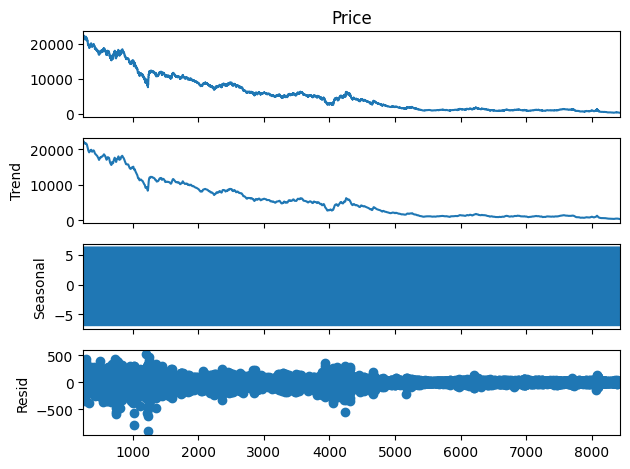

In [18]:
#Seasonal Decomposition for Seasonality
result = seasonal_decompose(df_train["Price"], model="additive", period=12)

result.plot()
plt.show()

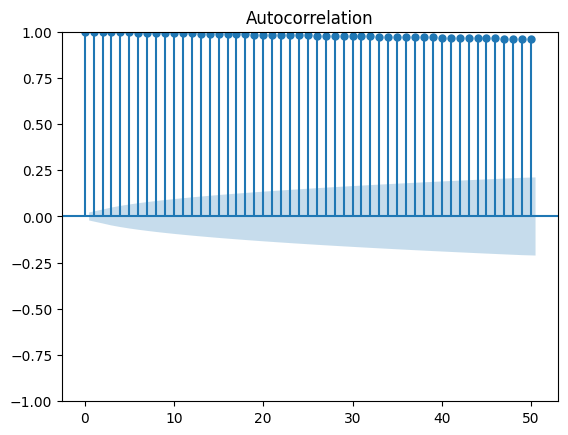

In [19]:
#ACF Test for Seasonality
plot_acf(df_train["Price"], lags=50)
plt.show()

### LINEAR REGRESSION

In [20]:
print(df.columns)
print(df_train.columns)
print(df_test.columns)


Index(['Time', 'Price', 'Time_numeric'], dtype='object')
Index(['Time', 'Price', 'Time_numeric'], dtype='object')
Index(['Time', 'Price', 'Time_numeric'], dtype='object')


In [21]:
X_train = df_train[["Time_numeric"]]
y_train = df_train["Price"]

X_test = df_test[["Time_numeric"]]
y_test = df_test["Price"]

Index(['Time', 'Price', 'Time_numeric'], dtype='object')
Index(['Time', 'Price', 'Time_numeric'], dtype='object')


In [22]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 9892.287674461799
Root Mean Squared Error (RMSE): 9946.369475691063


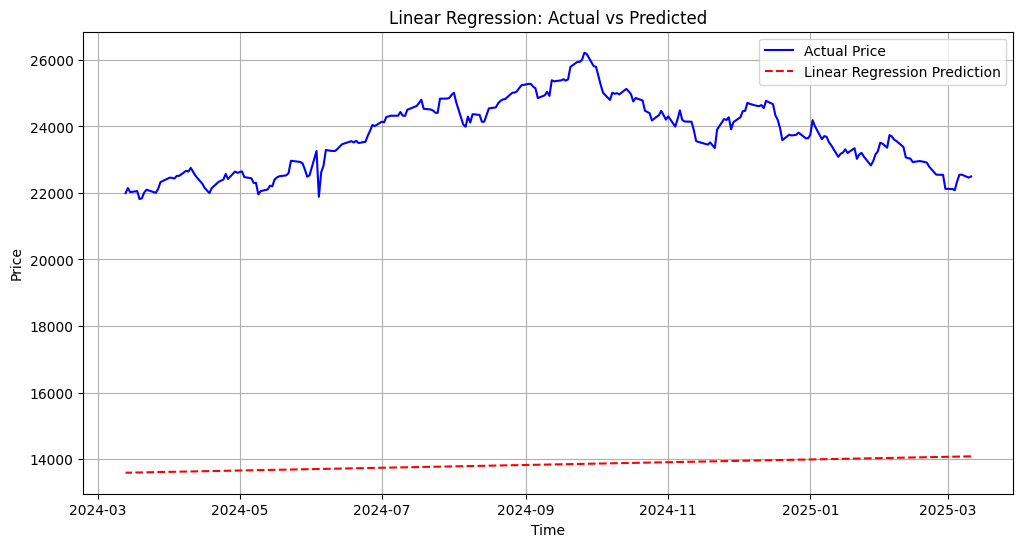

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test["Time"], y_test, label="Actual Price", color="blue")
plt.plot(df_test["Time"], y_pred, label="Linear Regression Prediction", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


### SARIMA

In [ ]:

# Find optimal parameters
stepwise_model = auto_arima(df_train["Price"], seasonal=True, m=12, trace=True)

# Print the best parameters
print(stepwise_model.summary())


In [ ]:
# Define SARIMA parameters
p, d, q = 5, 2, 0  # ARIMA parameters
P, D, Q, s = 0, 0, 1, 12  # Seasonal parameters, set 's' based on seasonality period

# Fit SARIMA model on training data
model = SARIMAX(df_train["Price"], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

sarima_result = model.fit()

# Print model summary
print(sarima_result.summary())

In [ ]:
# Forecast on test set
predictions = sarima_result.predict(start=len(df_train), 
                                    end=len(df_train) + len(df_test) - 1, 
                                    dynamic=False)

# Convert index to match test data
predictions.index = df_test.index

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train["Price"], label="Training Data", color="blue")
plt.plot(df_test.index, df_test["Price"], label="Actual Test Data", color="black")
plt.plot(predictions.index, predictions, label="SARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("SARIMA Model Predictions vs Actual Data")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_test["Price"], predictions)
mse = mean_squared_error(df_test["Price"], predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
